$\newcommand{\ket}[1]{{\left\vert{#1}\right\rangle}}$
$\newcommand{\bra}[1]{{\left\langle{#1}\right\vert}}$
# Algoritmo de Grover

Neste notebook, vamos apresentar o algoritmo Grover e implementar em `myQLM`.

Material de apoio:
- Capítulo 3 de https://proceedings.science/series/23/proceedings_non_indexed/13 
- Capítulo 7 de https://github.com/programaquantica/tutoriais/blob/master/programaquantica.pdf
- Capítulo 9 de https://arxiv.org/abs/2201.10574 


## Descrição do Algoritmo de Grover
Seja $N=2^n$ para algum inteiro $n$ e suponha que $f:\big\{0,\ldots,N-1\big\}\rightarrow \{0,1\}$ seja uma função booleana tal que $f(x)=1$ se e somente se $ x=x_0$ para algum valor fixo $x_0$. A expressão matemática de $f(x)$ é

\begin{equation*}\label{ag_f_x}
    f(x) = \left\{
  \begin{array}{l@{\quad}l}
    1, & \hbox{se ${x=x_0}$,} \\
    0, & \hbox{caso contrário.}
  \end{array}
\right.
\end{equation*} 

Suponha que $x_0$ seja desconhecido. Como podemos encontrar $x_0$ avaliando $f$? Do ponto de vista computacional, queremos avaliar a função o menor número de vezes.

Classicamente, o algoritmo mais eficiente consulta essa função $N$ vezes no pior caso. Usando um computador quântico, é possível melhorar o número de avaliações para $O(\sqrt N)$. Como é feito na prática? Temos que usar uma matriz unitária $U_{f}$ que implementa a função $f(x)$ em um computador quântico como um caixa preta. Podemos usar $U_{f}$, mas não podemos ver os detalhes da implementação de $U_{f}$. Cada vez que usamos $U_{f}$, adicionamos uma unidade à contagem. 



## Operadores
Consideramos um registrador de $n$ qubits de modo que um dos elementos da base computacional é dado por $|x_0\rangle$. Definimos inicialmente uma condição inicial uniforme

$$|\psi_0\rangle =  \frac{1}{\sqrt{2^n}}\sum_{i=0}^{2^n-1} |x\rangle$$

Daí, definimos os operadores:

$$U_{f} \ket{x}\ket{i}=\ket{x}\ket{i\oplus f(x)},$$
chamado de oráculo (codifica a função $f$), e

$$G = (2|\psi_0\rangle\langle \psi_0| - \mathrm{I}_N)\otimes \mathrm{I}_2, $$
chamado de operador de inversão em torno da média.

## Os passos do algoritmo

O algoritmo tem os seguintes passos (usando $n+1$ qubits)

1. Primeiro, preparar o estado inicial $\ket{\psi_0}\ket{-}$;

2. Aplicar o operator $U_f$;

3. Aplicar o operator $G$;

4. Repetir $t$ vezes os passos 2 e 3 onde

$$
t=\left\lfloor\frac{\pi}{4}\sqrt N\right\rfloor;
$$

5. Medir o primeiro registrador na base computacional.

A medição retorna o estado $x_0$ com probabilidade de aproximadamente $1 - \frac{1}{\sqrt{N}}$.

## Estudando o oráculo:

### Como implementar a caixa preta $U_f$?

Como $f(x)$ é uma função booleana cuja tabela verdade possui uma única linha com saída 1, $f(x)$ pode ser implementada com uma porta Toffoli generalizada ativada por $x_0$ (veja a seção 2.7 de https://arxiv.org/abs/2201.10574). $U_{f}$ é definida como

\begin{equation*}
    U_{f} \ket{x}\ket{i}=\ket{x}\ket{i\oplus f(x)},
\end{equation*} 

onde $x$ é uma cadeia de $n$-bit e $i$ é um bit. Observe que se tomarmos $i=0$, a equação anterior se reduz a

\begin{equation*}
    U_{f}\ket{x}\ket{0}=\left\{
                             \begin{array}{l@{\quad}l}
                               \ket{x_0}\ket{1}, & \hbox{se ${x=x_0}$,} \\
                               \ket{x}\ket{0}, & \hbox{caso contrário,}
                             \end{array}
                           \right.
\end{equation*}

que descreve a saída de uma porta Toffoli generalizada ativada por $x_0$ (e somente por $x_0$) quando a entrada é $\ket{x}\ket{0}$. O resultado do cálculo de $f(x)$ é armazenado no segundo registrador enquanto o estado do primeiro registro permanece inalterado.


Por exemplo, o circuito que implementa $U_{f}$ no caso $N=8$ e $x_0=6$, ou seja, $f(110)=1$ e $f(j)=0$ se $ j\neq 110$, é 

<img src="./circ_Tofolli_1.png" width="150px">

O primeiro registrador tem três qubits. Observe que o estado do segundo registro muda de $\ket{0}$ para $\ket{1}$ somente se a entrada para o primeiro registro for $\ket{110}$ porque 110 ativa os três controles e todos os outras cadeias de 3 bits não ativam.


In [1]:
from qat.lang.AQASM import *
import matplotlib.pyplot as plt
import math as m

In [2]:
#Elemento buscado é definido aqui: (o valor de n é também definido a partir do elemento escolhido)
x0 = (1,0,0,1,0)

# Definindo a subrotina Oráculo

#Criando rotina com n + 1 qubits
n = len(x0)
oraculo = QRoutine()
wires_oraculo = oraculo.new_wires(n + 1)

# Criando toffoli generalizada com controles abertos e fechados
for i,val in enumerate(x0):
    if val == 0:
        oraculo.apply(X,i)
        
X.ctrl(n)(wires_oraculo)

for i,val in enumerate(x0):
    if val == 0:
        oraculo.apply(X,i)
%qatdisplay oraculo --svg

### Mas o que representa?


No algoritmo de Grover, o estado do segundo registrador é sempre

$$
\ket{-}=\frac{\ket{0}-\ket{1}}{\sqrt 2}.
$$

Usando linearidade, a ação de $U_{f}$ é dada por

\begin{equation*}
    U_{f}\ket{x}\ket{-}=\left\{
                             \begin{array}{l@{\quad}l}
                               -\ket{x_0}\ket{-}, & \hbox{se ${x=x_0}$,} \\
                               \,\,\,\,\ket{x}\ket{-}, & \hbox{caso contrário.}
                             \end{array}
                           \right.
\end{equation*} 

Isto representa no primeiro registrador a aplicação de um operador $u$ que realiza $\textbf{uma reflexão em torno do espaço ortogonal à $\ket{x_0}$}$:

<img src="./u.png"  width=600  >

## Estudando o operador de inversão em torno da média
### Como implementar?

Vamos começar decompondo o que ocorre no primeiro registrador na definição abaixo:
$$G = (2|\psi_0\rangle\langle \psi_0| - \mathrm{I}_N)\otimes \mathrm{I}_2$$

Sabendo que $|\psi_0\rangle = H^{\otimes n}|0\rangle$, temos:
$$2|\psi_0\rangle\langle \psi_0| - \mathrm{I}_N = H^{\otimes n} (2|0\rangle\langle 0| - \mathrm{I}_N) H^{\otimes n}$$

Logo, tudo que deve ocorrer no primeiro registrador é a inversão do sinal de $|0\rangle$ entre a aplicação de portas de Hadamard. 

Usamos o fato do segundo registrador estar sempre no estado $|-\rangle$ para implementar $(2|0\rangle\langle 0| - \mathrm{I}_N)$ da forma:

<img src="./inversao0.png"  width=200 >

In [3]:
# Definindo a subrotina Amplificação
amp = QRoutine()
wires_amp = amp.new_wires(n+1)

for i in range (n):
    # Aplicar transformação | s> -> | 00..0> (porta H em todos os qbits)
    amp.apply(H, i)

    # Aplicar transformação | 00..0> -> | 11..1> (portas X)
    amp.apply(X, i)
    
# Construindo a porta CCZ
X.ctrl(n)(wires_amp)


# Transformando o estado de volta

for i in range (n):
    # Aplicar transformação | 11..1> -> | 00..0> (portas X)
    amp.apply(X, i)
    
    # Aplicar transformação | 00..0> -> | s>  (porta H em todos os qbits)
    amp.apply(H, i)
%qatdisplay amp --svg

### O que representa?

A ação do operador $G$ seguida do $U_f$ no estado inicial roda o vetor $\ket{\psi_0}$ no sentido anti-horário. O ângulo de rotação é $\theta$.

<img src="./g.png"  width=600 >

## Resultado final:

Cada iteração do passo de Grover faz uma rotação do vetor atual de $\theta$ graus em direção ao $\ket{x_0}$. Utilizamos um número $t$ de iterações que dê
$$t\theta \approx \frac{\pi}{2}$$
Deste modo, o estado final é tão próximo de $\ket{x_0}$ quanto era de $\ket{x_0}^\perp$ no início da execução. Note que errar o número de passos irá fazer nosso estado se afastar de $\ket{x_0}$.

Número ótimo de repetições: 4
Com 1 repetições: 
Estado |100100>: probabilidade 0.12915039062499967 amplitude (-0.35937499999999956+0j) 
Estado |100101>: probabilidade 0.12915039062499967 amplitude (0.35937499999999956+0j) 
Probabilidade de sucesso:  0.25830078124999933
******************************************************************************
Com 2 repetições: 
Estado |100100>: probabilidade 0.3012123107910143 amplitude (0.5488281249999988+0j) 
Estado |100101>: probabilidade 0.3012123107910143 amplitude (-0.5488281249999988+0j) 
Probabilidade de sucesso:  0.6024246215820286
******************************************************************************
Com 3 repetições: 
Estado |100100>: probabilidade 0.4484682679176302 amplitude (-0.6696777343749979+0j) 
Estado |100101>: probabilidade 0.4484682679176302 amplitude (0.6696777343749979+0j) 
Probabilidade de sucesso:  0.8969365358352605
******************************************************************************
Com 4 repetições: 
E

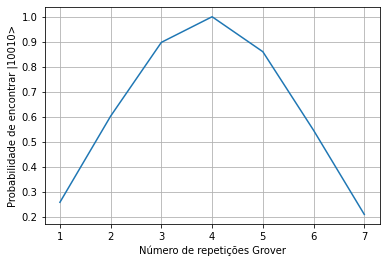

In [4]:
probs = []
repetitions = []

N = 2**n
t_opt = m.floor(m.pi*m.sqrt(N) / 4)
print('Número ótimo de repetições:',t_opt)

qprog = Program()

Qr = qprog.qalloc(n+1)
Cr = qprog.calloc(n+1)

# Initializing the first register as |psi_0>
for i in range (n):
    qprog.apply(H, Qr[i])

# Initializing the second register as |->
qprog.apply(X,Qr[n])
qprog.apply(H,Qr[n])

for i in range(1, t_opt*2):

    qprog.apply(oraculo,Qr)
    qprog.apply(amp,Qr)
    # Export this program into a quantum circuit
    circuit = qprog.to_circ()
    # import one Quantum Processor Unit Factory
    from qat.qpus import PyLinalg

    # Create a Quantum Processor Unit
    linalgqpu = PyLinalg()

    # Create a job
    job = circuit.to_job()

    # Submit the job to the QPU
    result = linalgqpu.submit(job)

    # Iterate over the final state vector to get all final components
    print('Com '+str(i)+' repetições: ')
    prob = 0
    for sample in result:
        if ('|' + ''.join(map(str,x0)) in str(sample.state)):
            print("Estado %s: probabilidade %s amplitude %s " % (sample.state, sample.probability, sample.amplitude))
            prob+=sample.probability
    print('Probabilidade de sucesso: ',prob)
    probs.append(prob)
    repetitions.append(i)
    print('******************************************************************************')
       
plt.plot(repetitions, probs)
plt.xlabel('Número de repetições Grover')
plt.ylabel('Probabilidade de encontrar '+'|' + ''.join(map(str,x0))+'>')
plt.grid(True)
plt.show()

In [5]:
%qatdisplay circuit --svg

# Exercícios

1. Estenda o algoritmo de Grover para mais do que 1 elemento marcado. Suponha que o número de elementos marcados seja $m$. Modifique apenas o operdor $U_f$ usando uma porta Toffoli multiqubit para cada elemento marcado. Faça uma implementação que mostre que tempo de execução ideal é $\left\lfloor\frac{\pi}{4}\sqrt{\frac{N}{m}}\right\rfloor$.

2. Implemente o algoritmo de Grover sem usar o segundo registrador. Use Capítulo 9 Seção 9.5 de https://arxiv.org/abs/2201.10574.

Observação: A solução destes exercícios será apresentada nas aulas Hands-on.